In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import nibabel as nib

# 4D-UNet model
from models import UNet4D 

from train_utils import predictions, CreateDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.set_default_dtype(torch.float32) 

Device: cuda


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

### Loading test data

In [ ]:
X_test_path = '../preprocessed_4d/ls_test'
y_test_path = '../preprocessed_4d/epi_test'

In [15]:
X_test_files = [f for f in os.listdir(X_test_path) if f.endswith('.pt')]
X_test = [torch.load(os.path.join(X_test_path, f)) for f in X_test_files]

C:\Users\Caroline\AppData\Local\Temp\ipykernel_12900\101806639.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = [torch.load(os.path.join(X_test_path, f)) for f i

In [16]:
y_test_files = [f for f in os.listdir(y_test_path) if f.endswith('.pt')]
y_test = [torch.load(os.path.join(y_test_path, f)) for f in y_test_files]

C:\Users\Caroline\AppData\Local\Temp\ipykernel_12900\4135945730.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_test = [torch.load(os.path.join(y_test_path, f)) for f 

### Loading the best model

In order to determine the generalizability, the best performing model is loaded and evaluated on the test data, which is previosly unseen for the model.

In [ ]:
test_dataset = CreateDataset(X_test, y_test)

best_MSE_model = UNet4D()


checkpoint_MSE = torch.load('./4D_model_weights/MSE_lr5e-5/weights_model_lr5e-05_epoch30.pth', map_location=device)
best_MSE_model.load_state_dict(checkpoint_MSE['model_state_dict'])

best_MSE_model.eval()

best_MSE_model.to(device=device)
set_seed(42)
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
preds, true = predictions(best_MSE_model, test_loader)

preds_cpu = preds[0].cpu()
true_cpu = true[0].cpu()
preds0= preds_cpu.squeeze(0,1)
true0= true_cpu.squeeze(0,1)

C:\Users\Caroline\AppData\Local\Temp\ipykernel_12900\2723243801.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MSE = torch.load('../../4D_models/4D_model_wei

### tSNR calculation

A common evaluation metric is signal-to-noise ratio (SNR), which measures the amount of background noise in comparison to the signal intensity. As the data is 4D, temporal SNR (tSNR) is calculated. SNR is calculated by taking the mean value of a region of interest (ROI) in the brain, dividing it on the standatd deviation of an ROI in the background.

The ROI positions were determined by visualization of the 4D volumes. For EPI and reconstructed LS the positions are the same, but due to head position, the ROI positions were shifted for the original LS volumes.

In [ ]:
def calc_SNR(image, image_type):
    """ 
    Calculation tSNR for three types of images. 

    Parameters:
    - image: 4D volume to calculate tSNR on.
    - image_type: Type of image to calculate tSNR on. The ROI will be defined differently depending on the image and position of the brain.

    Returns:
    - snr: The computed tSNR.

    Notes: The ROI positionts were determined by visalization of both the images and the selected ROIs.
    """
    
    if image_type == 'EPI':
        ROI_image = image[:,25:30,25:30,25:30]
        ROI_noise =  image[:,9:14,15:20,30:35] 
        
    elif image_type == 'Recon':
        ROI_image = image[:,25:30,25:30,25:30]
        ROI_noise = image[:,5:10,15:20,30:35] 

    elif image_type == 'LS':
        ROI_image =  image[:,25:30,25:30,35:40]
        ROI_noise = image[:,3:8,11:16,30:35]
    
    mean_signal = torch.mean(ROI_image)
    std_signal = torch.std(ROI_noise)

    print(mean_signal, std_signal)

    snr = mean_signal/(std_signal+1e-6) # Adding a small number to avoid division by zero

    return snr

### tSNR of EPI

In [145]:
calc_SNR(image=true0, image_type='EPI')

tensor(0.3794) tensor(0.0016)


tensor(229.9294)

### tSNR of predictions

In [147]:
calc_SNR(image=preds0, image_type='Recon')

tensor(0.3864) tensor(0.0086)


tensor(45.1855)

### Loading original LS data

In order of comparison, the tSNR was also calculated for the original LS volume, using the same participant as was used as test data. 

In [ ]:
orig_LS_path = 'Insert path'

orig_LS_img = nib.load(orig_LS_path).get_fdata()

In [ ]:
# Extracting the same temporal slices as used for the other calculations
orig_LS_img = orig_LS_img[:,:,:,120:172] 
orig_LS_img = torch.tensor(orig_LS_img, dtype=torch.float32)

# Reshaping the data to ensure the same shape as the other two volumes
orig_LS_img = orig_LS_img.permute(3,0,1,2) 

In [ ]:
# Checking that the LS volumes have the same shape as the other data
orig_LS_img.shape

torch.Size([52, 64, 64, 64])

### tSNR of original LS

In [9]:
calc_SNR(image=orig_LS_img, image_type='LS')

tensor(5034.2314) tensor(275.6186)


tensor(18.2652)

### Plotting SNR over time

To see the variations in SNR over time, the code calc_SNR was modified to also return a list of all SNR values in the 4D volume.

In [ ]:
def plot_SNR(image, image_type):
    """ 
    Calculation SNR for each time point for three types of images. 

    Parameters:
    - image: 4D volume to calculate tSNR on.
    - image_type: Type of image to calculate tSNR on. The ROI will be defined differently depending on the image and position of the brain.

    Returns:
    - snr: A list containing the computed SNR for each time point in the 4D volume.
    """
    
    if image_type == 'EPI':
        ROI_image = image[:,25:30,25:30,25:30]
        ROI_noise =  image[:,9:14,15:20,30:35] 

    elif image_type == 'Recon':
        ROI_image = image[:,25:30,25:30,25:30]
        ROI_noise = image[:,5:10,15:20,30:35] 

    elif image_type == 'LS':
        ROI_image =  image[:,25:30,25:30,35:40]
        ROI_noise = image[:,3:8,11:16,30:35]

    all_snrs = []
    
    for i in range(image.shape[0]):
        mean_signal = torch.mean(ROI_image[i])
        std_signal = torch.std(ROI_noise[i])

        snr = mean_signal/(std_signal+1e-6)
        all_snrs.append(snr)
    
    return all_snrs

In [21]:
epi_snr = plot_SNR(image=true0, image_type='EPI')
recon_snr = plot_SNR(image=preds0, image_type='Recon')
ls_snr = plot_SNR(image=orig_LS_img, image_type='LS')

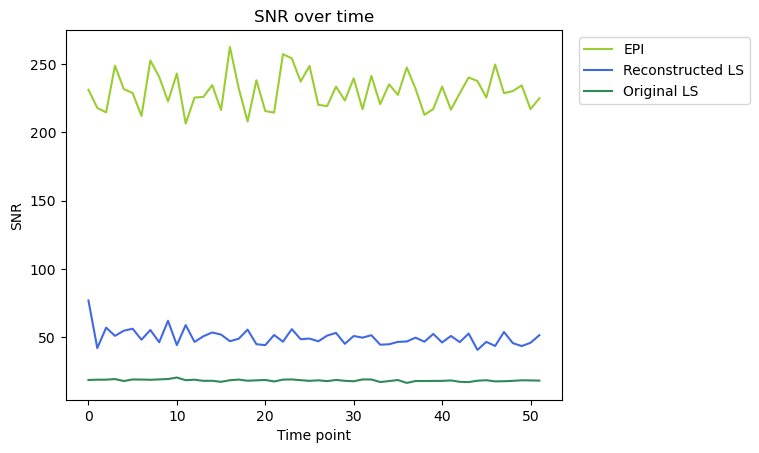

In [ ]:
x_values = [i for i in range(true0.shape[0])] # x values for plotting purposes

plt.plot(x_values, epi_snr, label = 'EPI', color = 'yellowgreen')
plt.plot(x_values, recon_snr, label = 'Reconstructed LS', color='royalblue')
plt.plot(x_values, ls_snr, label = 'Original LS', color = 'seagreen')
plt.legend(bbox_to_anchor =(1.02,1))
plt.title('SNR over time')
plt.xlabel('Time point')
plt.ylabel('SNR')
plt.show()